## Imports

### Data Access Imports

In [3]:
import pandas as pd
import pyarrow.parquet as pq
import s3fs

### Visualization Imports

In [4]:
import plotly.express as px
import matplotlib.pyplot as plt
import arcgis
from arcgis import GeoAccessor, GeoSeriesAccessor
from arcgis.gis import GIS

### Analysis Imports

In [ ]:
import geopandas as gpd

## Access Data

### Single Parquet

In [3]:
file_path = 's3://fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00000.snappy.parquet'

In [4]:
# Read directly from S3
df = pd.read_parquet(file_path, storage_options={'anon': True})

In [16]:
# print number of rows
print(f"Number of rows: {df.shape[0]}")

Number of rows: 4180424


In [7]:
# filter to rows with a lat and long in st joseph, mi
df = df[(df['latitude'] > 42.0) & (df['latitude'] < 42.1) & (df['longitude'] > -86.5) & (df['longitude'] < -86.4)]

### Iterate Parquets in S3

In [5]:
# Initialize S3 filesystem
s3 = s3fs.S3FileSystem(anon=True)

In [6]:
# S3 bucket and prefix
bucket_name = 'fsq-os-places-us-east-1'
prefix = 'release/dt=2024-11-19/places/parquet/'

In [7]:
# List all files in the prefix
files = s3.ls(f"{bucket_name}/{prefix}")

In [8]:
print(f"Number of files: {len(files)}")

Number of files: 25


In [9]:
print(files)

['fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00000.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00001.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00002.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00003.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00004.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00005.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00006.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00007.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00008.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00009.snappy.parquet', 'fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00010.snap

In [10]:
# Area of interest
min_lat, max_lat = 42.0, 42.2
min_lon, max_lon = -86.5, -86.3

In [11]:
# Iterate through files and filter data
filtered_data = []
for file in files:
    # Read the Parquet file
    file_path = f"s3://{file}"
    table = pq.read_table(file_path, filesystem=s3)
    df = table.to_pandas()

    # Filter by latitude and longitude
    df_filtered = df[
        (df['latitude'] >= min_lat) & (df['latitude'] <= max_lat) &
        (df['longitude'] >= min_lon) & (df['longitude'] <= max_lon)
    ]

    # Append the filtered data
    filtered_data.append(df_filtered)

In [12]:
# Combine all filtered data into a single DataFrame
final_df = pd.concat(filtered_data, ignore_index=True)

In [13]:
# print number of rows
print(f"Number of rows: {final_df.shape[0]}")

Number of rows: 5489


In [14]:
final_df.head()

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,date_closed,tel,website,email,facebook_id,instagram,twitter,fsq_category_ids,fsq_category_labels,dt
0,51b61c23498e967c2f08eddf,Family Therapy,42.090938,-86.495788,M63,St.Joe,MI,49085,None,None,...,None,None,None,None,NaN,None,None,[4bf58dd8d48988d177941735],[Health and Medicine > Physician > Doctor's Of...,2024-11-19
1,3bed8b33a77d42418e6c5fa1,Ray Hbb,42.158663,-86.358904,2569 Kerlikowske Rd,Benton Harbor,MI,49022,None,None,...,None,(269) 757-7447,None,None,NaN,None,None,[63be6904847c3692a84b9b85],[Business and Professional Services > Real Est...,2024-11-19
2,4fa27394e4b01308e7bae590,post,42.013976,-86.494090,None,Stevensville,MI,49127,None,None,...,2018-04-11,None,None,None,NaN,None,None,None,None,2024-11-19
3,d91db561902942fca02b21bd,Family Circle Dentistry PLC,42.120655,-86.476907,455 Upton Dr,Saint Joseph,MI,49085,None,None,...,None,(269) 983-7881,http://www.familycircledentistry.com,None,NaN,None,None,[4bf58dd8d48988d178941735],[Health and Medicine > Dentist],2024-11-19
4,5a88cebda87921721f919555,SpineCare Decompression and Chiropractic Center,42.060139,-86.460849,3134 Niles Road,St. Joseph,MI,49085,None,None,...,None,(269) 408-8439,https://www.bestspinecare.com,info@bestspinecare.com,2.156876e+14,None,stjoechiro,[52e81612bcbc57f1066b7a3a],[Health and Medicine > Chiropractor],2024-11-19


In [15]:
# save final_df to a csv file
final_df.to_csv('location_filtered_places.csv', index=False)

## Visualize Data

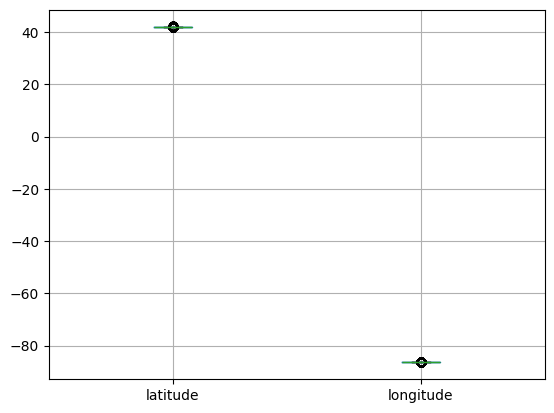

In [16]:
# make a matplotlib box plot of latitude and longitude
fig, ax = plt.subplots()
final_df.boxplot(column=['latitude', 'longitude'], ax=ax)
plt.show()

In [17]:
sedf = arcgis.features.GeoAccessor.from_xy(final_df, x_column='longitude', y_column='latitude', sr=4326)

In [18]:
gis = GIS()
map = gis.map('Michigan')
map

Map(center=[5484837.632514392, -9372733.492175287], extent={'xmin': -9787509.914871024, 'ymin': 4924123.621923…

In [19]:
# add the sedf to the map
sedf.spatial.plot(map)

c:\Users\ggarcia\OneDrive - Abonmarche\Documents\GitHub\Geopandas\.venv\Lib\site-packages\pandas\core\dtypes\cast.py:1056: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\ggarcia\OneDrive - Abonmarche\Documents\GitHub\Geopandas\.venv\Lib\site-packages\pandas\core\dtypes\cast.py:1080: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


True